In [1]:
import numpy as np
import torch 
import sys
sys.path.append("../")

import tqdm
import yaml
torch.random.manual_seed(300)
import matplotlib.pyplot as plt

import utils_BayTIDE as utils

from model_BayTIDE import BayTIDE

from model_LDS import LDS_GP_streaming
import time

In [37]:
import numpy as np
import torch 
import sys
sys.path.append("../")

import tqdm
import yaml
torch.random.manual_seed(300)
import matplotlib.pyplot as plt

import utils_BayTIDE as utils

from model_BayTIDE import BayTIDE

from model_LDS import LDS_GP_streaming
import time

config_path = "./config_simu_scalability.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

data_file = config["data_path"] 

hyper_dict = utils.make_hyper_dict(config)

data_dict = utils.make_data_dict(hyper_dict,data_file,fold=0)

model = BayTIDE(hyper_dict,data_dict)

# model.post_W_m =   torch.ones(  model.N, model.K, 1,).double().to(model.device)#  (N,K,1) 

model.reset()

INNER_ITER = hyper_dict["INNER_ITER"]
EVALU_T = hyper_dict["EVALU_T"]

start = time.time()

for epoch in range(1):
    model.reset()
    for T_id in tqdm.tqdm(range(model.T)):
        model.filter_predict(T_id)
        model.msg_llk_init()

        if model.mask_train[:,T_id].sum()>0: # at least one obseved data at current step
            for inner_it in range(INNER_ITER):

                flag = (inner_it == (INNER_ITER - 1))

                model.msg_approx_U(T_id)
                model.filter_update(T_id,flag)

                model.msg_approx_W(T_id)
                model.post_update_W(T_id)



            model.msg_approx_tau(T_id)
            model.post_update_tau(T_id)

        else:
            model.filter_update_fake(T_id)
        if T_id % EVALU_T == 0 or T_id == model.T - 1:
            pass
            # pred, loss_dict = model.model_test(T_id)
            # print("T_id = {}, train_rmse = {:.2f}, test_rmse= {:.2f}".format(T_id, loss_dict["train_RMSE"], loss_dict["test_RMSE"]))
    # model.smooth()
    print("time = {:.2f}".format(time.time()-start))




    # model.post_update_U_after_smooth(0)
    # pred, loss_dict = model.model_test(T_id)
    # print("after smooth, train_rmse = {:.2f}, test_rmse= {:.2f},  test_MAE= {:.2f}".format(loss_dict["train_RMSE"] ,loss_dict["test_RMSE"], loss_dict["test_MAE"]))



use device: cuda


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [01:17<00:00, 51.46it/s]

time = 77.73


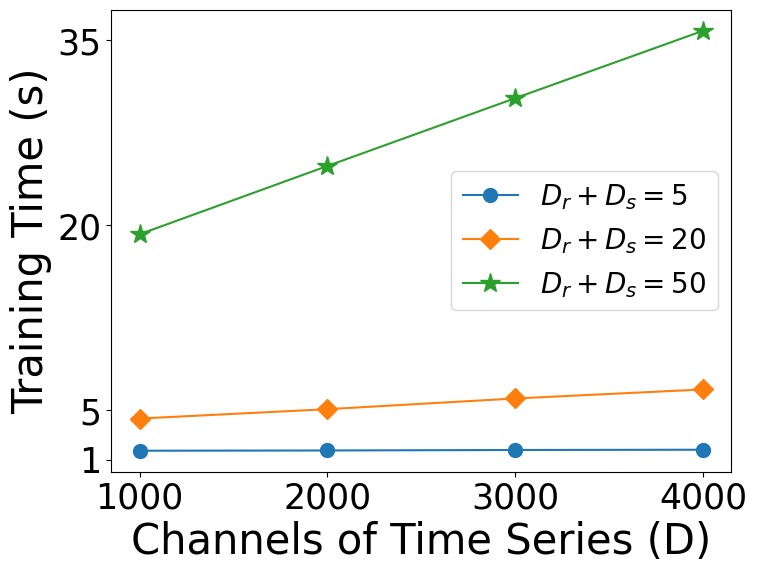

In [3]:
# scalability over D
fc_5 =[1.72,
1.74,
1.78,
1.8]

fc_20 = [4.33,
5.09,
5.96,
6.69
]

fc_50 = [19.28,
24.82,
30.32,
35.79
]

# plot three lines and scatter plot

D = [1000, 2000, 3000, 4000]

plt.figure(figsize=(8, 6))



plt.plot(D, fc_5, label=r"$D_r + D_s =5$", marker='o',markersize=10)
plt.plot(D, fc_20, label=r"$D_r + D_s =20$", marker='D',markersize=10)
plt.plot(D, fc_50, label=r"$D_r + D_s =50$", marker='*',markersize=15)

plt.xlabel('Channels of Time Series (D)',fontsize=30)
plt.ylabel('Training Time (s)',fontsize=30)
plt.xticks([1000, 2000, 3000, 4000],fontsize=25)
plt.yticks([1, 5, 20, 35],fontsize=25)
plt.legend(fontsize=20)
plt.savefig("./figs/scalability_D_no_smooth.pdf", bbox_inches='tight')

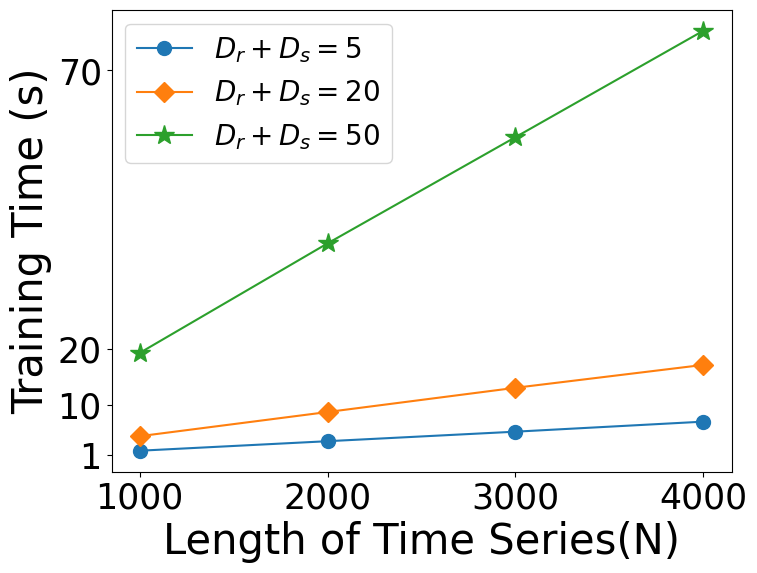

In [4]:
# scalability over T
fc_5 =[1.72,
3.43,
5.14,
6.94]

fc_20 = [4.33,
8.67,
13.02,
17.13
]

fc_50 = [19.28,
38.95,
58.02,
77.13
]

# plot three lines and scatter plot

D = [1000, 2000, 3000, 4000]

plt.figure(figsize=(8, 6))



plt.plot(D, fc_5, label=r"$D_r + D_s =5$", marker='o',markersize=10)
plt.plot(D, fc_20, label=r"$D_r + D_s =20$", marker='D',markersize=10)
plt.plot(D, fc_50, label=r"$D_r + D_s =50$", marker='*',markersize=15)
plt.xlabel('Length of Time Series(N)',fontsize=30)
plt.ylabel('Training Time (s)',fontsize=30)
plt.xticks([1000, 2000, 3000, 4000],fontsize=25)
plt.yticks([1, 10, 20, 70],fontsize=25)
plt.legend(fontsize=20)

# save as pdf
plt.savefig("./figs/scalability_N_no_smooth.pdf", bbox_inches='tight')
